In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
# load data
df = pd.read_csv("PJME_hourly.csv")

In [3]:
df.describe()

PJME_MW
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000

In [4]:
df.columns

Index(['Datetime', 'PJME_MW'], dtype='object')

In [5]:
df.head()

Datetime  PJME_MW
0  2002-12-31 01:00:00  26498.0
1  2002-12-31 02:00:00  25147.0
2  2002-12-31 03:00:00  24574.0
3  2002-12-31 04:00:00  24393.0
4  2002-12-31 05:00:00  24860.0

In [6]:
# set date as index

df['Datetime']=pd.to_datetime(df['Datetime'])
df.set_index('Datetime',inplace=True)

In [7]:
df.head()

PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0

### Data Cleaning & EDA

<Axes: xlabel='Datetime'>

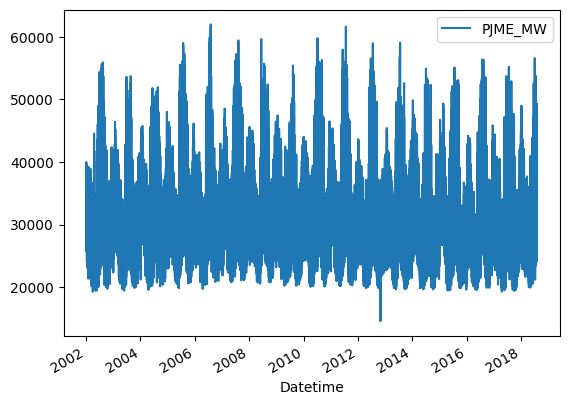

In [8]:
df.plot()

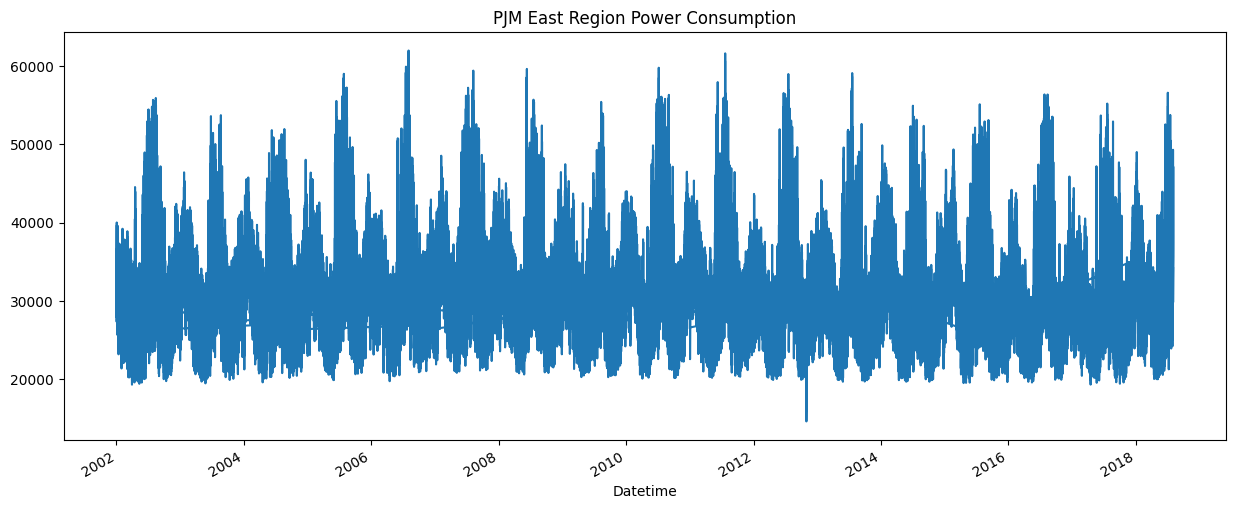

In [9]:
# Full Dataset Line Plot
df.plot(figsize=(15, 6), title="PJM East Region Power Consumption", legend=False)
plt.show()


C:\Users\heetb\AppData\Local\Temp\ipykernel_25112\2993622950.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean()
C:\Users\heetb\AppData\Local\Temp\ipykernel_25112\2993622950.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.resample('Y').mean()


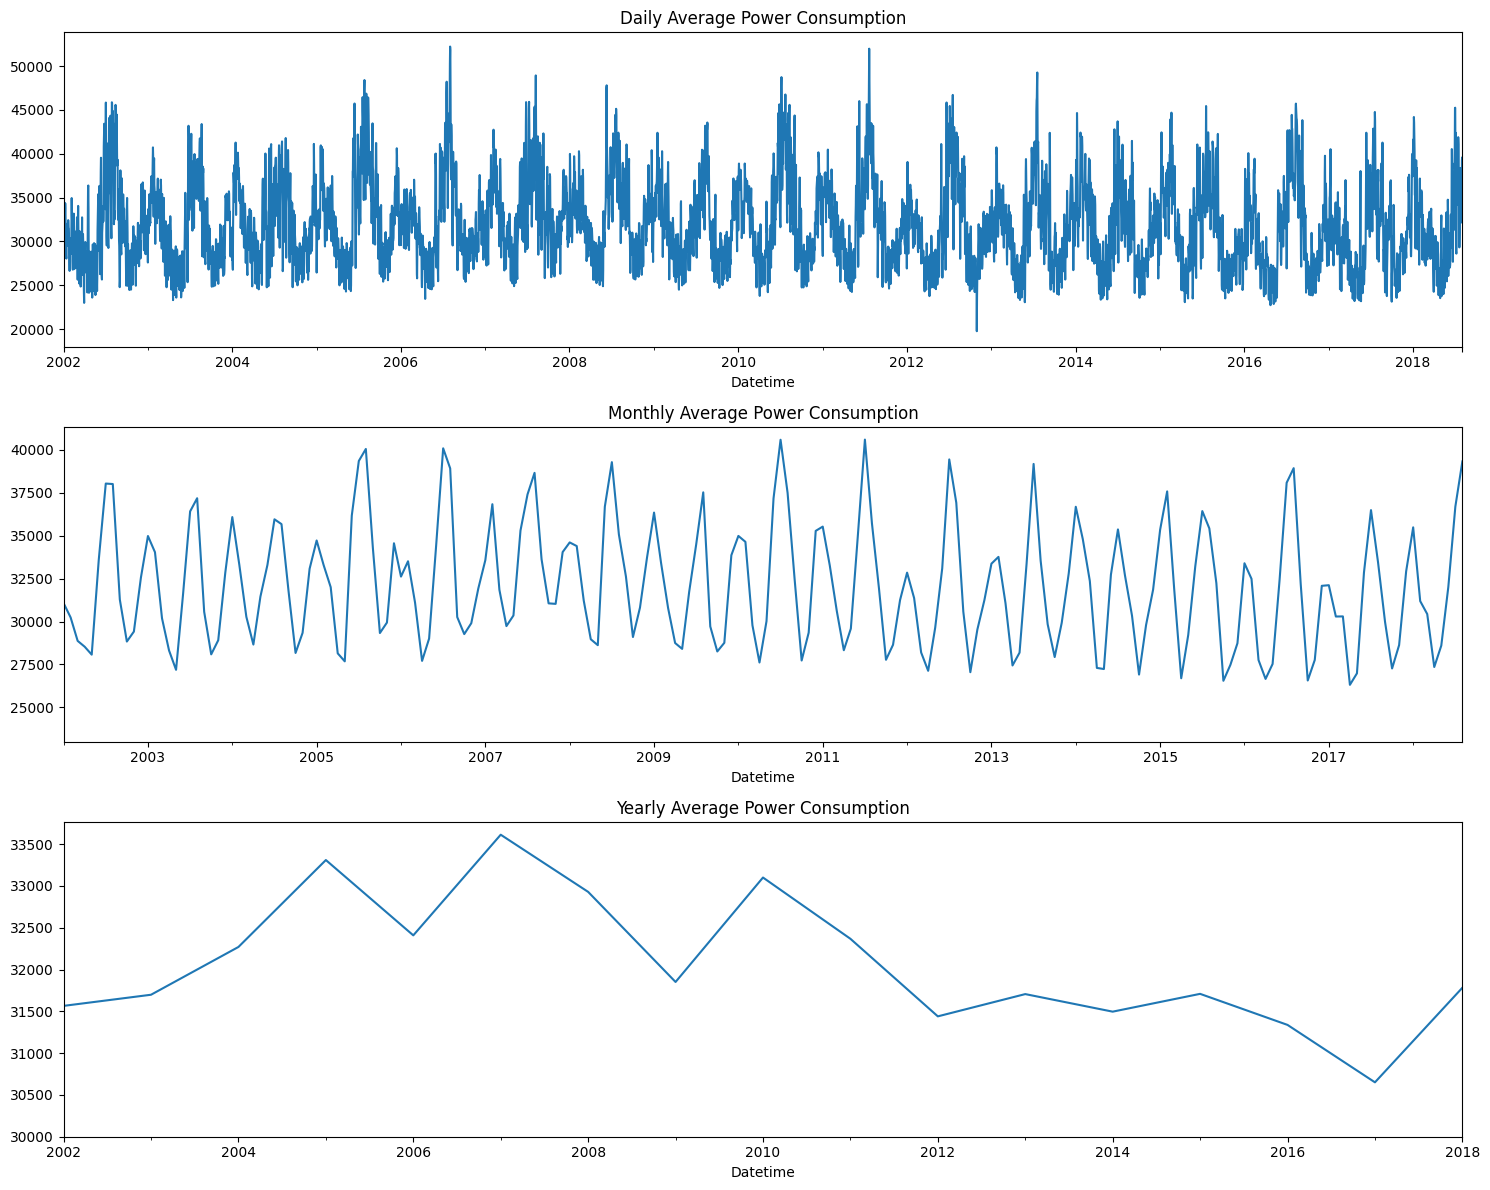

In [10]:
# Aggregated Views
df_daily = df.resample('D').mean()
df_monthly = df.resample('M').mean()
df_yearly = df.resample('Y').mean()

fig, axes = plt.subplots(3, 1, figsize=(15, 12))
df_daily.plot(ax=axes[0], title="Daily Average Power Consumption", legend=False)
axes[0].set_ylim(18000)
df_monthly.plot(ax=axes[1], title="Monthly Average Power Consumption", legend=False)
axes[1].set_ylim(23000)
df_yearly.plot(ax=axes[2], title="Yearly Average Power Consumption", legend=False)
axes[2].set_ylim(30000)
plt.tight_layout()
plt.show()


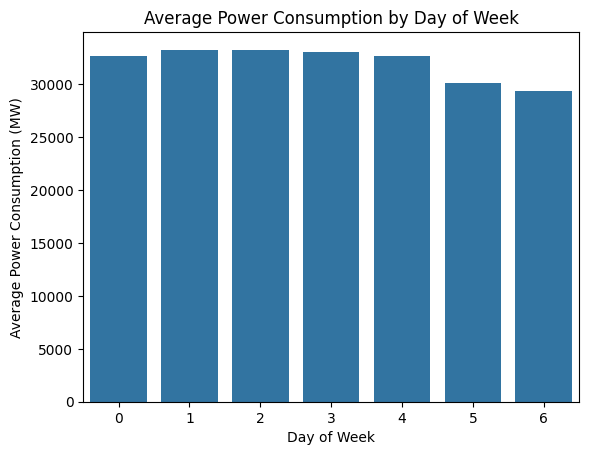

In [11]:
df['dayofweek'] = df.index.dayofweek
weekly_avg = df.groupby('dayofweek')['PJME_MW'].mean()

sns.barplot(x=weekly_avg.index, y=weekly_avg.values)  
plt.title("Average Power Consumption by Day of Week")
plt.xlabel("Day of Week")  
plt.ylabel("Average Power Consumption (MW)") 
plt.show()

In [12]:
# check for stationarity

from statsmodels.tsa.stattools import adfuller

# ADF Test
adf_test = adfuller(df['PJME_MW'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

if adf_test[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary.")


ADF Statistic: -18.828912729084074
p-value: 2.022124508152674e-30
Critical Values: {'1%': -3.430395009088914, '5%': -2.861559893380481, '10%': -2.5667805885384065}
The data is stationary.


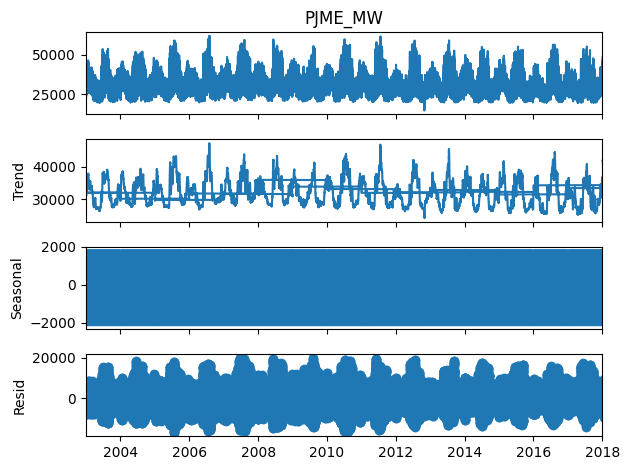

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df['PJME_MW'], model='additive', period=24*7)
decomposition.plot()
plt.show()


There is obviously seasonality. As a result, we will sarima model to get better result.

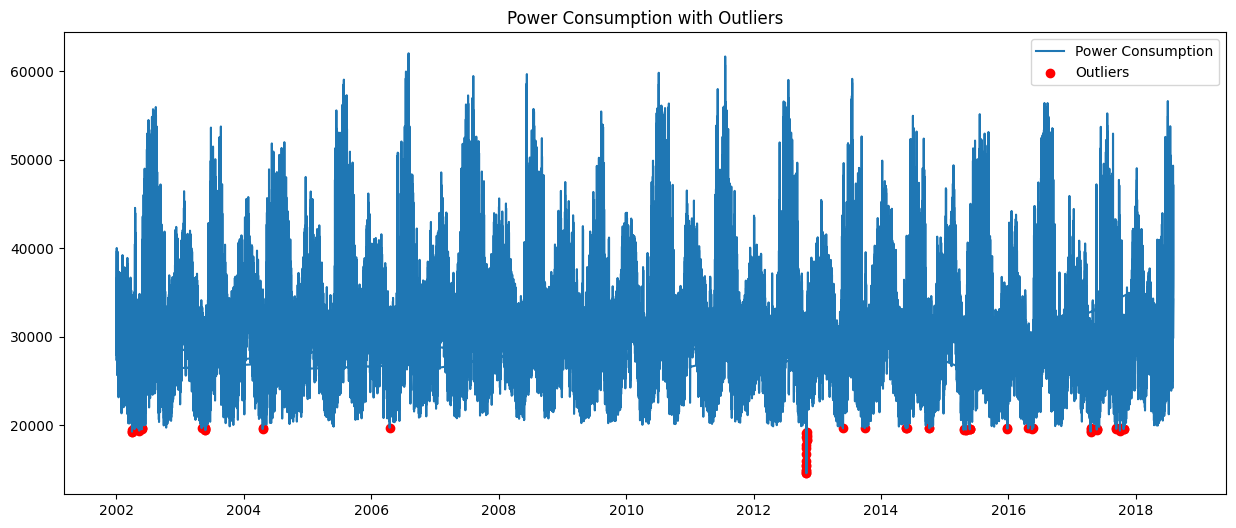

In [14]:
# detect anamolies exist or not.
outliers = df[(df['PJME_MW'] < df['PJME_MW'].quantile(0.0005))]

plt.figure(figsize=(15, 6))
plt.plot(df['PJME_MW'], label="Power Consumption")
plt.scatter(outliers.index, outliers['PJME_MW'], color='red', label='Outliers')
plt.legend()
plt.title("Power Consumption with Outliers")
plt.show()


In [15]:
# Remove outliers.

threshold = df['PJME_MW'].quantile(0.0005)
df_cleaned = df[df['PJME_MW'] >= threshold]

print(f"Original data size: {len(df)}")
print(f"Cleaned data size: {len(df_cleaned)}")

Original data size: 145366
Cleaned data size: 145294


In [16]:
# check for null values.
df_cleaned.isna().sum()

PJME_MW      0
dayofweek    0
dtype: int64

In [17]:
def create_time_features(df):
    """
    Generate time-based features from the index.
    """
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    
    return df

# # Apply the function
# df_cleaned = create_time_features(df_cleaned)

# # Preview the updated DataFrame 
# print(df_cleaned.head())


In [18]:
def add_lag_features(df, target, num_lags):
    """
    Add lagged features for the target variable.
    
    Parameters:
    - df: DataFrame
    - target: Name of the target column
    - num_lags: Number of lags to create
    """
    for lag in range(1, num_lags + 1):
        df[f'lag_{lag}'] = df[target].shift(lag)
    return df


#### Split data into train and test

Training data size: 101705
Testing data size: 43589


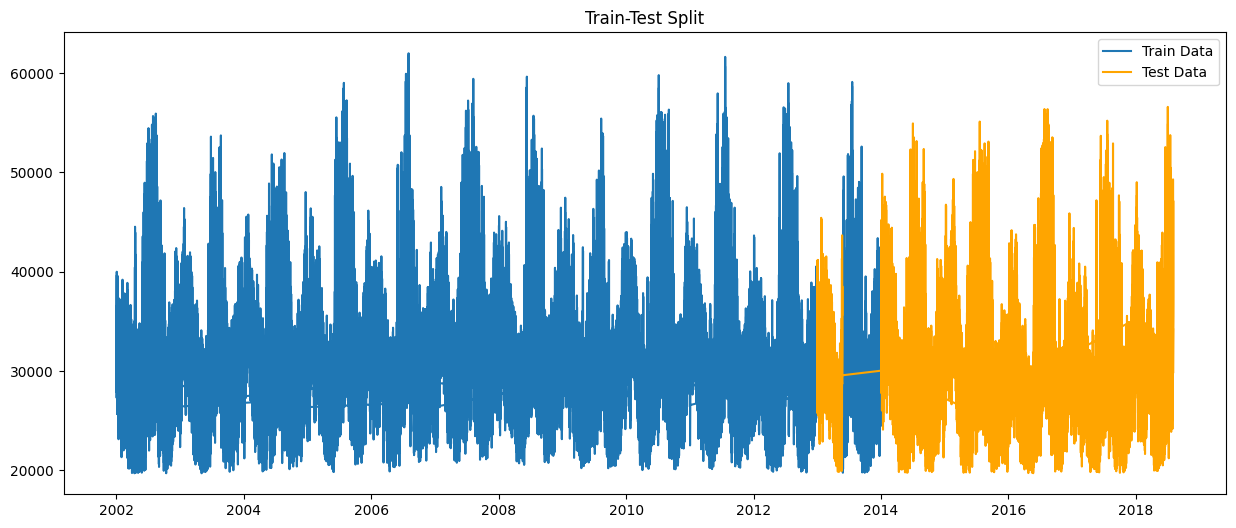

In [19]:
split_idx = int(len(df_cleaned) * 0.7)

train_data = df_cleaned[:split_idx]
test_data = df_cleaned[split_idx:]

# sizes of each dataset
print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

#Plot the train-test split for visualization

plt.figure(figsize=(15, 6))
plt.plot(train_data['PJME_MW'], label="Train Data")
plt.plot(test_data['PJME_MW'], label="Test Data", color='orange')
plt.legend()
plt.title("Train-Test Split")
plt.show()

#### This is first time I am seeing this issue. After some time I realised that It's just the unsorted index. That's why this is happening. So let us sort it and divide the the data again.

Training data size: 101705
Testing data size: 43589


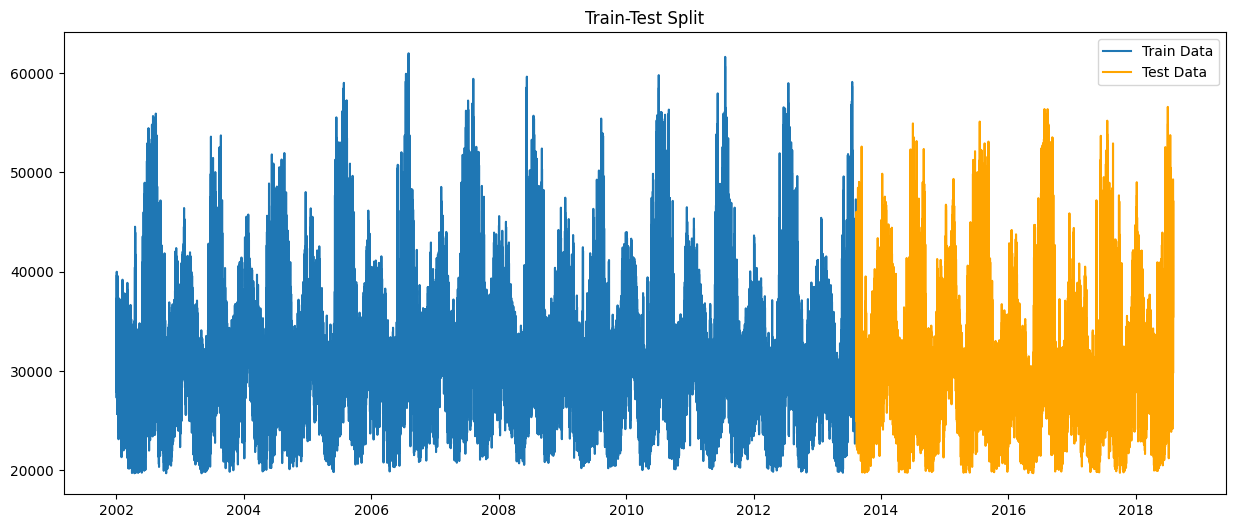

In [20]:
df_cleaned = df_cleaned.sort_index()

train_data = df_cleaned[:split_idx]
test_data = df_cleaned[split_idx:]

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

plt.figure(figsize=(15, 6))
plt.plot(train_data['PJME_MW'], label="Train Data")
plt.plot(test_data['PJME_MW'], label="Test Data", color='orange')
plt.legend()
plt.title("Train-Test Split")
plt.show()

## SARIMA model

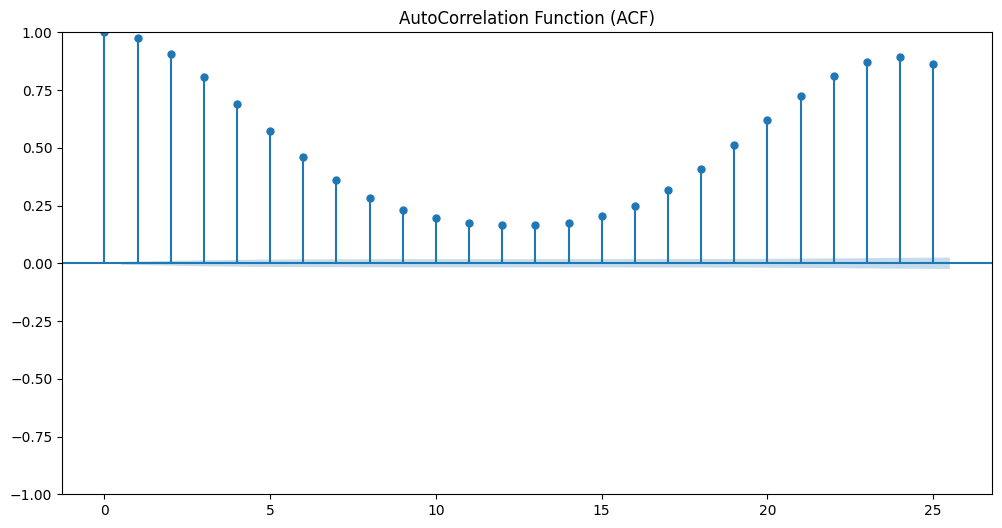

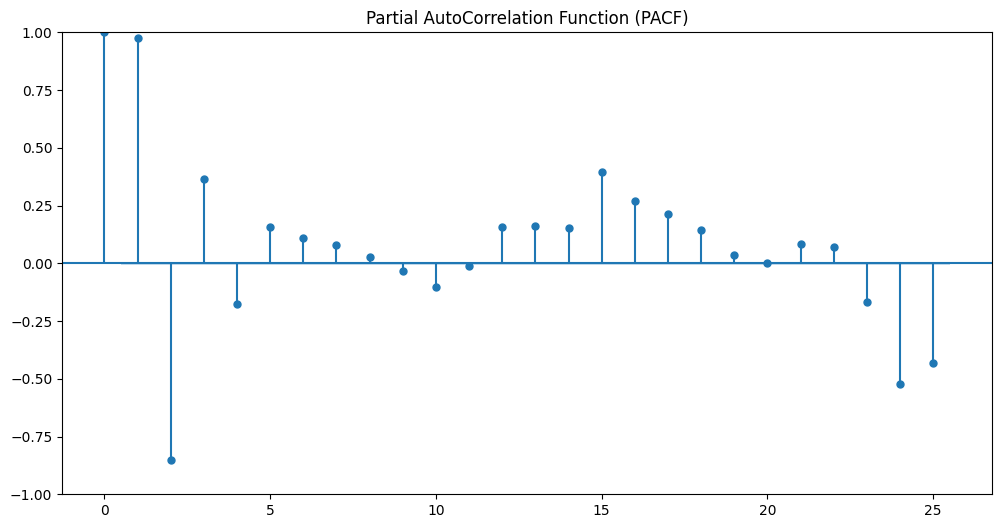

In [21]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(train_data['PJME_MW'], lags=25, ax=plt.gca(), title="AutoCorrelation Function (ACF)")
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(train_data['PJME_MW'], lags=25, ax=plt.gca(), title="Partial AutoCorrelation Function (PACF)")
plt.show()

In [22]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error
# import itertools
# import numpy as np

# # Define a function for SARIMA grid search
# def sarima_grid_search(train, test, param_grid, seasonal_param_grid, seasonal_period):
#     """
#     Grid search for SARIMA model to find the best parameters.
#     """
#     best_aic = np.inf
#     best_params = None
#     best_model = None
    
#     for param in param_grid:
#         for seasonal_param in seasonal_param_grid:
#             try:
#                 # Fit SARIMA model
#                 model = SARIMAX(
#                     train,
#                     order=param,
#                     seasonal_order=seasonal_param + (seasonal_period,),
#                     enforce_stationarity=False,
#                     enforce_invertibility=False,
#                 )
#                 results = model.fit(disp=False)
                
#                 # Check if AIC improves
#                 if results.aic < best_aic:
#                     best_aic = results.aic
#                     best_params = (param, seasonal_param)
#                     best_model = results
#             except:
#                 continue
    
#     return best_params, best_model

# # Define parameter ranges
# p = d = q = range(0, 3)  # Non-seasonal params (p, d, q)
# P = D = Q = range(0, 2)  # Seasonal params (P, D, Q)
# s = 24  # Assuming daily seasonality for hourly data

# # Generate parameter combinations
# param_grid = list(itertools.product(p, d, q))
# seasonal_param_grid = list(itertools.product(P, D, Q))

# # Perform grid search
# best_params, best_model = sarima_grid_search(
#     train_data['PJME_MW'], 
#     test_data['PJME_MW'], 
#     param_grid, 
#     seasonal_param_grid, 
#     s
# )

# # Print the best parameters
# print("Best Parameters:", best_params)

# # Forecast using the best model
# forecast = best_model.forecast(steps=len(test_data))
# test_data['SARIMA_Predicted'] = forecast

# # Plot the results
# import plotly.graph_objects as go

# fig = go.Figure()

# # Add actual test data
# fig.add_trace(go.Scatter(
#     x=test_data.index, 
#     y=test_data['PJME_MW'], 
#     mode='lines', 
#     name='Actual Test Data',
#     line=dict(color='blue')
# ))

# # Add SARIMA predictions
# fig.add_trace(go.Scatter(
#     x=test_data.index, 
#     y=test_data['SARIMA_Predicted'], 
#     mode='lines', 
#     name='SARIMA Predicted',
#     line=dict(color='orange')
# ))

# # Update layout
# fig.update_layout(
#     title="SARIMA Model: Test Data vs Predictions",
#     xaxis_title="Datetime",
#     yaxis_title="Power Consumption (MW)",
#     template="plotly_white"
# )

# fig.show()


#### This is taking too much time so we will convert hourly data into daily data. then we try above action.

In [23]:
# Downsample to daily frequency if data is hourly
df_resampled = df_cleaned['PJME_MW'].resample('D').mean()

# Split the resampled data into train-test
split_idx = int(len(df_resampled) * 0.7)
train_resampled = df_resampled[:split_idx]
test_resampled = df_resampled[split_idx:]


In [24]:
from pmdarima import auto_arima

# Fit the auto_arima model on training data
auto_model = auto_arima(
    train_resampled, 
    seasonal=True, 
    m=7,
    trace=True, 
    suppress_warnings=True, 
    stepwise=True
)

# Display the best parameters
print(auto_model.summary())

# Get best SARIMA parameters
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=6.95 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=83656.252, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=77083.088, Time=1.50 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=78751.173, Time=1.94 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=100220.603, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=78002.327, Time=0.14 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=76885.992, Time=5.28 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=10.54 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=77060.089, Time=3.96 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=83595.251, Time=7.22 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=76551.908, Time=16.28 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=76710.974, Time=2.75 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=14.000, Time=43.76 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=76707.591, Time=5.51 sec
 ARIMA(2,0,0)(2,0,2)[7] interc

C:\Users\heetb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\stattools.py:1431: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
C:\Users\heetb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [25]:
# pip install pmdarima

In [26]:
# Best model:  ARIMA(2,0,0)(2,0,1)[7]


best_order = [2,0,0]
best_seasonal_order = [2,0,1,7]
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model using the best parameters
sarima_model = SARIMAX(
    train_resampled, 
    order=best_order, 
    seasonal_order=best_seasonal_order, 
    enforce_stationarity=False, 
    enforce_invertibility=False
)
sarima_results = sarima_model.fit()

# Forecast on the test set
forecast = sarima_results.forecast(steps=len(test_resampled))
test_resampled = test_resampled.to_frame(name='PJME_MW')  # Ensure it's a DataFrame
test_resampled['SARIMA_Predicted'] = forecast

# Evaluate performance
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_resampled['PJME_MW'], test_resampled['SARIMA_Predicted'])
print(f"SARIMA Model Mean Squared Error: {mse}")


SARIMA Model Mean Squared Error: 28821479.702823475


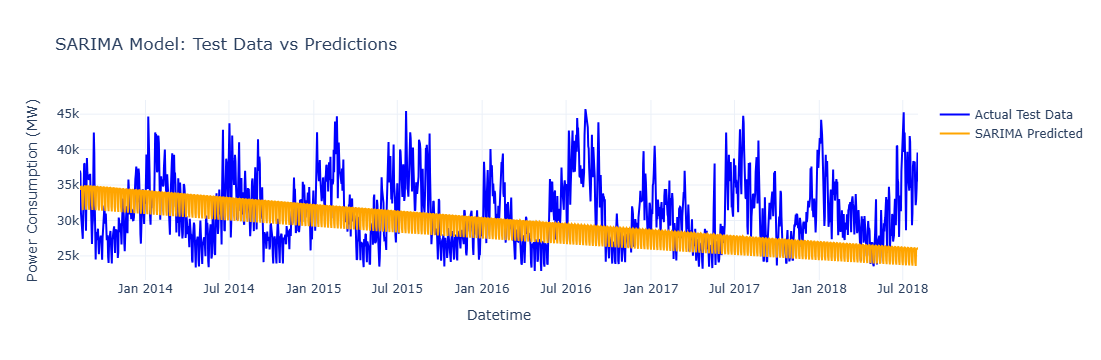

In [27]:
# Plot actual vs predicted values
import plotly.graph_objects as go

fig = go.Figure()

# Add actual test data
fig.add_trace(go.Scatter(
    x=test_resampled.index, 
    y=test_resampled['PJME_MW'], 
    mode='lines', 
    name='Actual Test Data',
    line=dict(color='blue')
))

# Add SARIMA predictions
fig.add_trace(go.Scatter(
    x=test_resampled.index, 
    y=test_resampled['SARIMA_Predicted'], 
    mode='lines', 
    name='SARIMA Predicted',
    line=dict(color='orange')
))

# Update layout
fig.update_layout(
    title="SARIMA Model: Test Data vs Predictions",
    xaxis_title="Datetime",
    yaxis_title="Power Consumption (MW)",
    template="plotly_white"
)

fig.show()


### Result:
- there is more than one seasonality in this data. and SARIma can handle only one seasonality, That is why it is failing.

## Stacked LSTM

In [28]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_cleaned['PJME_MW'].values.reshape(-1, 1))

In [29]:
# Define a function to create sequences for supervised learning
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Create sequences
time_steps = 30  # Use past 30 timesteps to predict the next
X, y = create_sequences(data_scaled, time_steps)


In [30]:
# Split into train and test sets
split_idx = int(len(X) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (101684, 30, 1)
Test set shape: (43580, 30, 1)


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the Stacked LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer for single-step prediction
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Display the model architecture
model.summary()


C:\Users\heetb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# pip install tensorflow

In [33]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
3178/3178 ━━━━━━━━━━━━━━━━━━━━ 79s 24ms/step - loss: 0.0054 - val_loss: 4.7681e-04
Epoch 2/20
3178/3178 ━━━━━━━━━━━━━━━━━━━━ 76s 24ms/step - loss: 5.9347e-04 - val_loss: 3.6926e-04
Epoch 3/20
3178/3178 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - loss: 4.0997e-04 - val_loss: 1.3079e-04
Epoch 4/20
3178/3178 ━━━━━━━━━━━━━━━━━━━━ 77s 24ms/step - loss: 3.7808e-04 - val_loss: 1.4243e-04
Epoch 5/20
3178/3178 ━━━━━━━━━━━━━━━━━━━━ 79s 25ms/step - loss: 3.4983e-04 - val_loss: 1.3511e-04
Epoch 6/20
3178/3178 ━━━━━━━━━━━━━━━━━━━━ 80s 25ms/step - loss: 3.2531e-04 - val_loss: 1.1285e-04
Epoch 7/20
3178/3178 ━━━━━━━━━━━━━━━━━━━━ 81s 25ms/step - loss: 3.1232e-04 - val_loss: 9.9108e-05
Epoch 8/20
3178/3178 ━━━━━━━━━━━━━━━━━━━━ 81s 25ms/step - loss: 2.9664e-04 - val_loss: 2.7673e-04
Epoch 9/20
3178/3178 ━━━━━━━━━━━━━━━━━━━━ 80s 25ms/step - loss: 2.8842e-04 - val_loss: 9.0348e-05
Epoch 10/20
3178/3178 ━━━━━━━━━━━━━━━━━━━━ 80s 25ms/step - loss: 2.7698e-04 - val_loss: 8.8819e-05
Epoch 11/20
3178/3178 ━

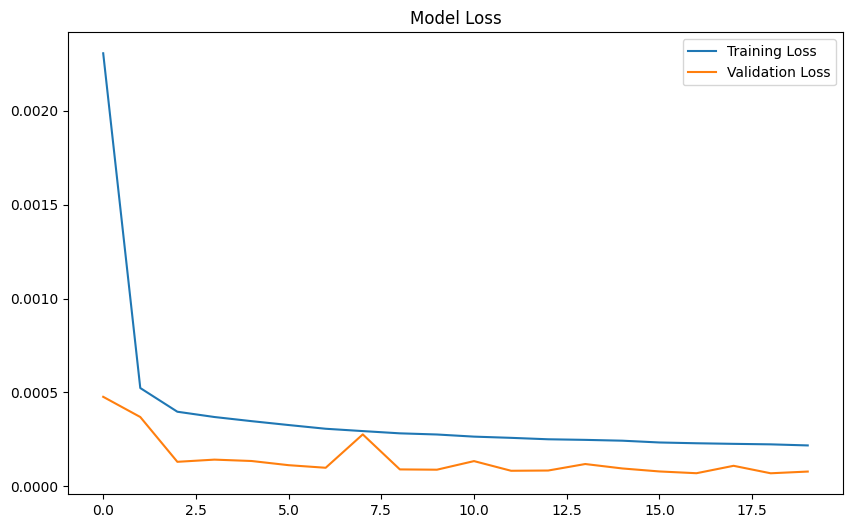

1362/1362 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step


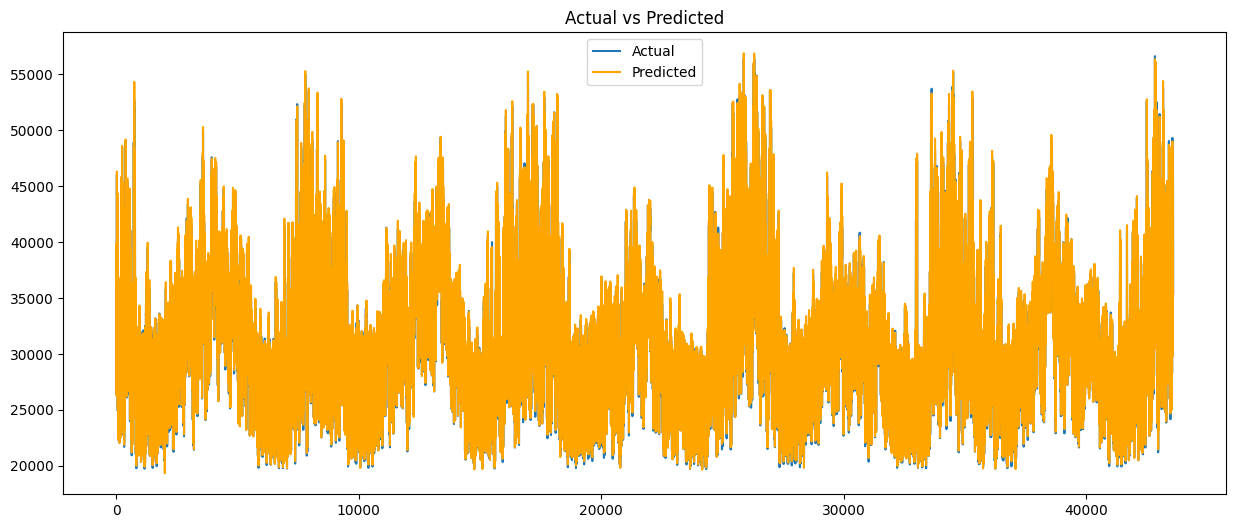

In [34]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Predict on the test set
y_pred = model.predict(X_test)

# Reverse scaling
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Visualize actual vs predicted
plt.figure(figsize=(15, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted', color='orange')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()


In [72]:
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print("RMSE for lstm:", rmse)

RMSE for lstm: 375.84747652484106


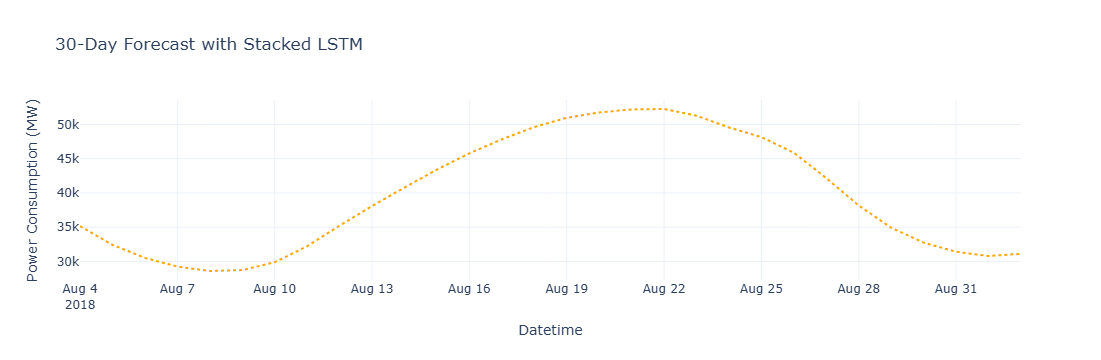

In [35]:
def forecast_lstm(model, input_sequence, steps=30, scaler=None):
    """
    Forecast future values using a trained LSTM model.

    :param model: Trained LSTM model
    :param input_sequence: The last `time_steps` values (normalized)
    :param steps: Number of future time steps to predict
    :param scaler: Scaler used for normalization (optional, for inverse scaling)
    :return: Array of forecasted values
    """
    forecast = []
    current_input = input_sequence[-1].copy()  # Start with the last input sequence

    for _ in range(steps):
        # Reshape input to match LSTM input shape
        current_input_reshaped = current_input.reshape(1, current_input.shape[0], current_input.shape[1])
        
        # Predict the next value
        next_value = model.predict(current_input_reshaped, verbose=0)
        forecast.append(next_value[0][0])  # Append the scalar prediction

        # Update the input sequence with the predicted value
        current_input = np.roll(current_input, -1, axis=0)  # Shift input
        current_input[-1] = next_value  # Add the new prediction

    # Reverse scaling if scaler is provided
    if scaler:
        forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

    return forecast

# Use the last `time_steps` data points for forecasting
input_sequence = X[-time_steps:]  # Last `time_steps` rows from normalized data

# Forecast 30 days
forecast_30_days = forecast_lstm(model, input_sequence, steps=30, scaler=scaler)

# Create a DataFrame for visualization
forecast_index = pd.date_range(start=df_cleaned.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_df = pd.DataFrame({'Forecast': forecast_30_days}, index=forecast_index)

# Visualize the forecast
import plotly.graph_objects as go

fig = go.Figure()

# Add forecast data
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df['Forecast'],
    mode='lines',
    name='30-Day Forecast',
    line=dict(color='orange', dash='dot')
))

# Update layout
fig.update_layout(
    title="30-Day Forecast with Stacked LSTM",
    xaxis_title="Datetime",
    yaxis_title="Power Consumption (MW)",
    template="plotly_white"
)

fig.show()


### XGBoost

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming the lag and time features were created earlier using your custom functions
df_features = df_cleaned.copy()

df_features.head()
# Apply the feature functions
df_features = create_time_features(df_features)
df_features = add_lag_features(df_features, target='PJME_MW', num_lags=30)

# Drop rows with NaN values caused by lagging
df_features = df_features.dropna()

# Define target and features
X = df_features.drop(columns=['PJME_MW'])
y = df_features['PJME_MW']

# Normalize features for XGBoost
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=False)


In [37]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Initialize XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"XGBoost Regressor RMSE: {rmse}")


XGBoost Regressor RMSE: 354.97537153516384


C:\Users\heetb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



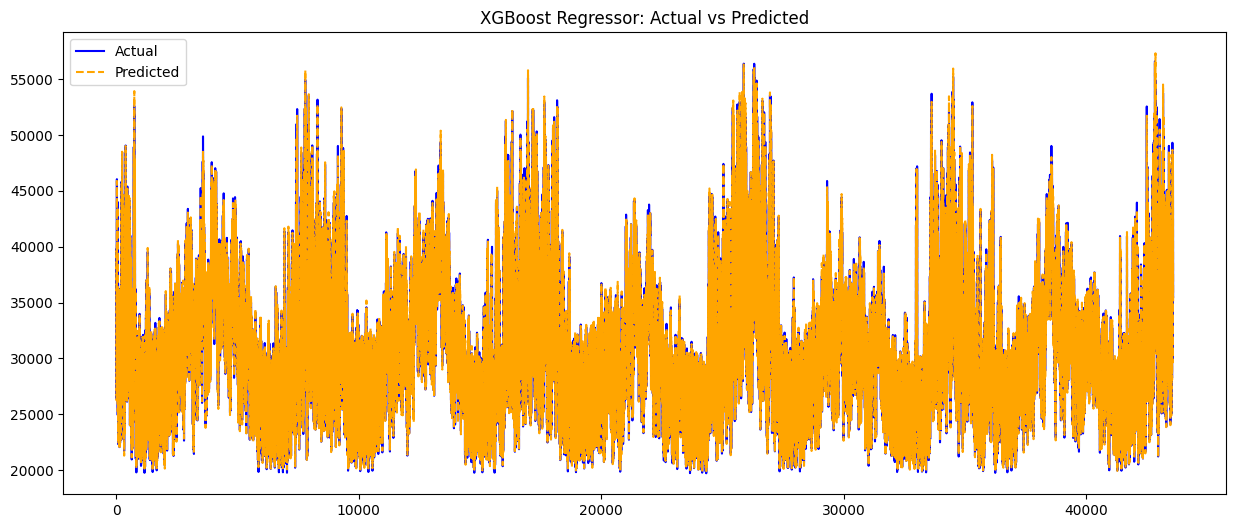

In [38]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange', linestyle='--')
plt.legend()
plt.title('XGBoost Regressor: Actual vs Predicted')
plt.show()


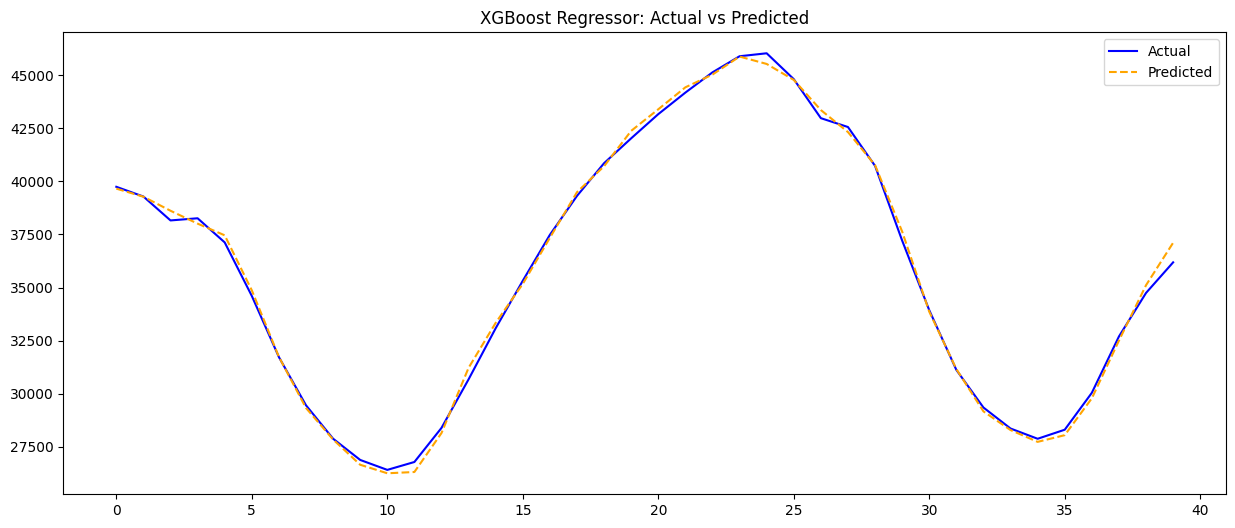

In [39]:
# let us zoom a little bit
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:40], label='Actual', color='blue')
plt.plot(y_pred[:40], label='Predicted', color='orange', linestyle='--')
plt.legend()
plt.title('XGBoost Regressor: Actual vs Predicted')
plt.show()


In [40]:
def forecast_xgboost(model, input_features, steps=30, scaler=None):
    """
    Forecast future values using XGBoost.
    
    :param model: Trained XGBoost model
    :param input_features: Most recent feature values (normalized)
    :param steps: Number of future time steps to predict
    :param scaler: Scaler for inverse transformation (optional)
    :return: Forecasted values
    """
    forecast = []  # Store predicted values
    current_features = input_features[-1].reshape(1, -1)  # Start with the last input features

    for step in range(steps):
        # Predict the next step
        next_value = model.predict(current_features)[0]
        forecast.append(next_value)

        # Update features: roll and add the new prediction to the last column
        current_features = np.roll(current_features, -1, axis=1)
        current_features[0, -1] = next_value  # Replace the last column with the prediction

    # Reverse scaling if scaler is provided
    if scaler:
        forecast_array = np.array(forecast).reshape(-1, 1)
        forecast = scaler.inverse_transform(
            np.hstack([np.zeros((steps, input_features.shape[1] - 1)), forecast_array])
        )[:, -1]  # Extract the last column

    return forecast


# Test the function
forecast_30_days_xgb = forecast_xgboost(xgb_model, X_scaled, steps=30, scaler=scaler)

# Print the results
print("30-Day Forecast:", forecast_30_days_xgb)


30-Day Forecast: [2.26790315e+08 2.54573034e+08 2.72831864e+08 2.78315237e+08
 2.74344851e+08 2.95610708e+08 3.00007467e+08 3.00116343e+08
 3.02395874e+08 2.93380040e+08 2.85163645e+08 2.73078677e+08
 2.64066222e+08 2.49895812e+08 2.35009686e+08 2.27618311e+08
 2.12767250e+08 1.97960536e+08 1.88532343e+08 1.90845475e+08
 1.95842350e+08 2.01055438e+08 2.20181076e+08 2.35695836e+08
 2.60759181e+08 2.81251606e+08 2.93366090e+08 2.99482486e+08
 3.10110799e+08 3.24833813e+08]


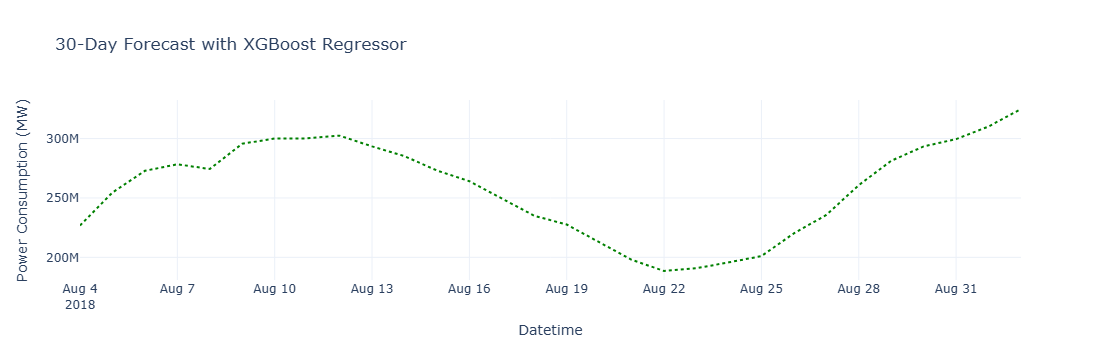

In [41]:
# Create a DataFrame for visualization
forecast_index = pd.date_range(start=df_cleaned.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_df_xgb = pd.DataFrame({'Forecast': forecast_30_days_xgb}, index=forecast_index)

# Visualize the forecast
import plotly.graph_objects as go

fig = go.Figure()

# Add XGBoost forecast
fig.add_trace(go.Scatter(
    x=forecast_df_xgb.index,
    y=forecast_df_xgb['Forecast'],
    mode='lines',
    name='XGBoost 30-Day Forecast',
    line=dict(color='green', dash='dot')
))

# Update layout
fig.update_layout(
    title="30-Day Forecast with XGBoost Regressor",
    xaxis_title="Datetime",
    yaxis_title="Power Consumption (MW)",
    template="plotly_white"
)

fig.show()

### Prophet

In [42]:
# pip install prophet

In [43]:
# prophet_model = Prophet(
#     daily_seasonality=True, 
#     yearly_seasonality=True, 
#     seasonality_mode='multiplicative',  # or 'additive'
#     changepoint_prior_scale=0.05  # Increase if there's too much noise in the forecast
# )
# prophet_model.fit(train_prophet)


In [44]:
from prophet import Prophet

# # Prepare the data for Prophet (daily frequency)
# df_daily = df_cleaned.resample('D').sum().reset_index()
# df_daily.columns = ['ds', 'y']

df_resampled = df_cleaned['PJME_MW'].resample('D').mean().reset_index()
df_resampled.columns = ['ds', 'y']

In [45]:
# Split into train and test (same split as before)
train_size = int(len(df_resampled) * 0.7)
train_prophet = df_resampled[:train_size]
test_prophet = df_resampled[train_size:]


In [46]:
# Initialize the Prophet model

prophet_model = Prophet()
prophet_model.fit(train_prophet)

20:20:46 - cmdstanpy - INFO - Chain [1] start processing
20:20:46 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
from prophet import Prophet
from prophet.make_holidays import make_holidays_df

# Generate U.S. holidays from 2002 to 2019
holidays_df = make_holidays_df(year_list=list(range(2002, 2020)), country='US')

# Initialize Prophet with holidays
prophet_model = Prophet(holidays=holidays_df)
prophet_model.fit(df_resampled)


20:20:47 - cmdstanpy - INFO - Chain [1] start processing
20:20:47 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
from sklearn.model_selection import ParameterGrid
import numpy as np

param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'seasonality_prior_scale': [1.0, 5.0, 10.0]
}

best_model = None
best_rmse = float('inf')

# Helper function to compute RMSE
def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Store best parameters
best_params = {}

for params in ParameterGrid(param_grid):
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays=holidays_df
    )
    model.fit(df_resampled)

    # Forecast and compare against actuals
    forecast = model.predict(df_resampled[['ds']])
    rmse = compute_rmse(df_resampled['y'], forecast['yhat'])
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_params = params

print(f"Best RMSE: {best_rmse}")
print(f"Best Parameters: {best_params}")


20:20:48 - cmdstanpy - INFO - Chain [1] start processing
20:20:48 - cmdstanpy - INFO - Chain [1] done processing
20:20:50 - cmdstanpy - INFO - Chain [1] start processing
20:20:50 - cmdstanpy - INFO - Chain [1] done processing
20:20:51 - cmdstanpy - INFO - Chain [1] start processing
20:20:52 - cmdstanpy - INFO - Chain [1] done processing
20:20:53 - cmdstanpy - INFO - Chain [1] start processing
20:20:54 - cmdstanpy - INFO - Chain [1] done processing
20:20:55 - cmdstanpy - INFO - Chain [1] start processing
20:20:56 - cmdstanpy - INFO - Chain [1] done processing
20:20:57 - cmdstanpy - INFO - Chain [1] start processing
20:20:57 - cmdstanpy - INFO - Chain [1] done processing
20:20:59 - cmdstanpy - INFO - Chain [1] start processing
20:21:00 - cmdstanpy - INFO - Chain [1] done processing
20:21:01 - cmdstanpy - INFO - Chain [1] start processing
20:21:02 - cmdstanpy - INFO - Chain [1] done processing
20:21:04 - cmdstanpy - INFO - Chain [1] start processing
20:21:05 - cmdstanpy - INFO - Chain [1]

Best RMSE: 2819.07055713217
Best Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


In [49]:
# Let u smake our final model with with best parameters and added holidays.
model = Prophet(
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=10.0,
        holidays=holidays_df
    )
model.fit(df_resampled)

20:21:06 - cmdstanpy - INFO - Chain [1] start processing
20:21:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 3100.9293577190447


C:\Users\heetb\AppData\Local\Temp\ipykernel_25112\3879965115.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\heetb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



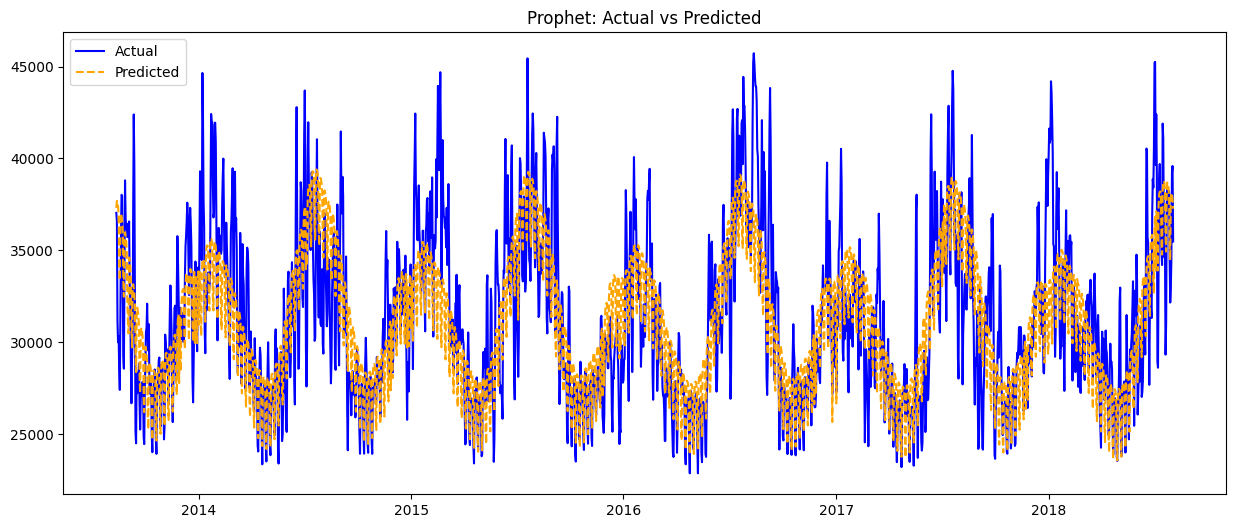

In [50]:
# Create a dataframe for future predictions (test set period)
future_test = test_prophet[['ds']]

# Predict on the test set
forecast_test = prophet_model.predict(future_test)

# Add predictions to the test dataframe
test_prophet['yhat'] = forecast_test['yhat']

# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse_prophet = mean_squared_error(test_prophet['y'], forecast_test['yhat'], squared=False)
print(f"Prophet RMSE: {rmse_prophet}")

# Plot actual vs predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual', color='blue')
plt.plot(test_prophet['ds'], forecast_test['yhat'], label='Predicted', color='orange', linestyle='--')
plt.legend()
plt.title('Prophet: Actual vs Predicted')
plt.show()

In [51]:
# Forecast the next 30 days
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Extract forecasted values for the next 30 days
forecast_30_days_prophet = forecast[['ds', 'yhat']].tail(30)
print(forecast_30_days_prophet)

             ds          yhat
6059 2018-08-04  34620.609365
6060 2018-08-05  33789.290816
6061 2018-08-06  37075.154063
6062 2018-08-07  37452.731798
6063 2018-08-08  37350.927919
6064 2018-08-09  37160.720301
6065 2018-08-10  36628.129798
6066 2018-08-11  33994.346631
6067 2018-08-12  33175.127652
6068 2018-08-13  36470.709355
6069 2018-08-14  36854.546491
6070 2018-08-15  36754.600394
6071 2018-08-16  36561.066134
6072 2018-08-17  36019.361174
6073 2018-08-18  33370.266165
6074 2018-08-19  32529.331008
6075 2018-08-20  35796.790854
6076 2018-08-21  36146.301852
6077 2018-08-22  36006.220907
6078 2018-08-23  35767.318837
6079 2018-08-24  35175.750082
6080 2018-08-25  32473.170176
6081 2018-08-26  31576.114840
6082 2018-08-27  34785.886173
6083 2018-08-28  35077.256660
6084 2018-08-29  34879.716202
6085 2018-08-30  34585.152524
6086 2018-08-31  33940.789073
6087 2018-09-01  31189.272571
6088 2018-09-02  30248.024912


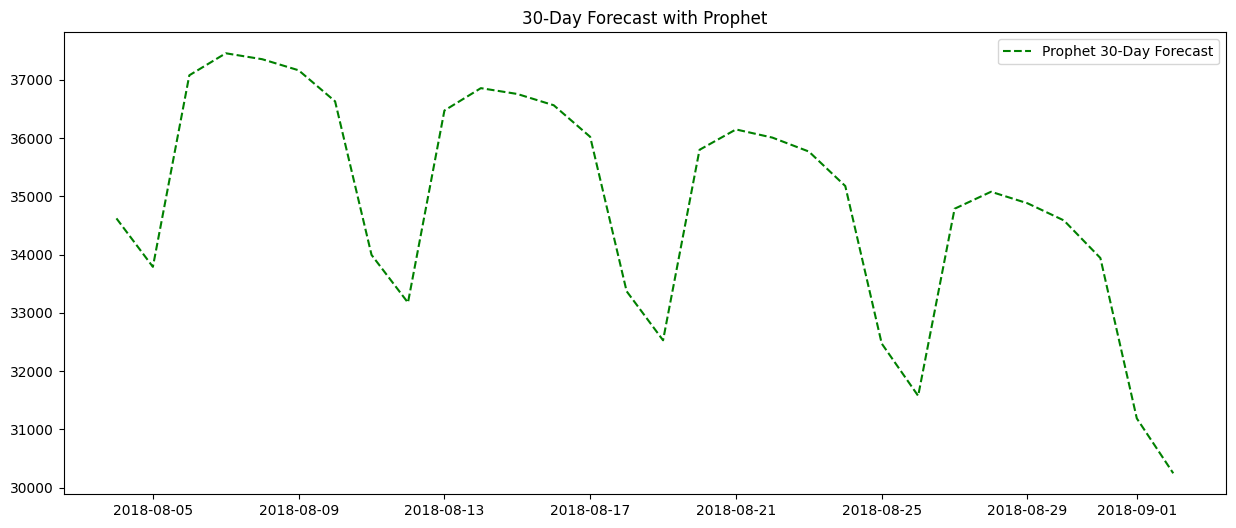

In [52]:
# Plot 30-day forecast
plt.figure(figsize=(15, 6))
# plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual', color='blue')
plt.plot(forecast_30_days_prophet['ds'], forecast_30_days_prophet['yhat'], label='Prophet 30-Day Forecast', color='green', linestyle='--')
plt.legend()
plt.title('30-Day Forecast with Prophet')
plt.show()

In [70]:
# Let's compare
import matplotlib.pyplot as plt

# Create a DataFrame for forecast comparison
forecast_df = pd.DataFrame({
    'Date': pd.date_range(start=df_cleaned.index[-1] + pd.Timedelta(days=1), periods=30, freq='D'),
    # 'SARIMA': forecast_30_days_sarima,
    'XGBoost': forecast_30_days_xgb,
    'Stacked_LSTM': forecast_30_days,
    'Prophet': forecast_30_days_prophet['yhat'].values
})

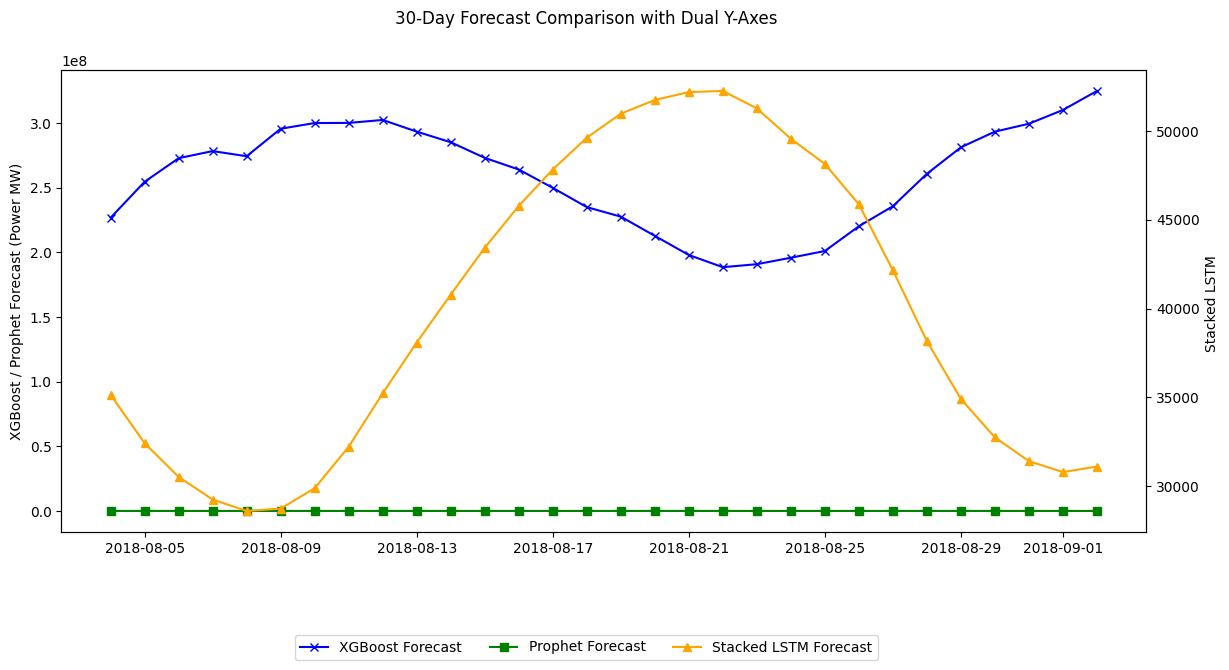

In [69]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot XGBoost and Prophet forecasts on the primary y-axis
ax1.plot(forecast_df['Date'], forecast_df['XGBoost'], label='XGBoost Forecast', color='blue', marker='x')
ax1.plot(forecast_df['Date'], forecast_df['Prophet'], label='Prophet Forecast', color='green', marker='s')
ax1.set_ylabel('XGBoost / Prophet Forecast (Power MW)')
ax1.tick_params(axis='y')

# Create a secondary y-axis for the Stacked LSTM and SARIMA models
ax2 = ax1.twinx()
ax2.plot(forecast_df['Date'], forecast_df['Stacked_LSTM'], label='Stacked LSTM Forecast', color='orange', marker='^')
ax2.set_ylabel('Stacked LSTM ')
ax2.tick_params(axis='y')

# Title and Legends
fig.suptitle('30-Day Forecast Comparison with Dual Y-Axes')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
plt.show()



#### RMSE comparison:

- RMSE for lstm: 375.84747652484106
- XGBoost Regressor RMSE: 354.97537153516384
- Best RMSE Prophet: 2819.07055713217
